In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes
from time import time

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,IsolationForest
from sklearn.preprocessing import RobustScaler  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

properati = pd.read_csv('datos/properati_final.csv')
#test_samples = pd.read_csv('datos/properati_dataset_testing_noprice_acondicionado.csv',error_bad_lines=False)


<IPython.core.display.Javascript object>

In [19]:
properati.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136356 entries, 0 to 136355
Data columns (total 25 columns):
created_on                    136356 non-null datetime64[ns]
property_type                 136356 non-null object
place_name                    136356 non-null object
state_name                    136356 non-null object
lat-lon                       136356 non-null object
lat                           96345 non-null float64
lon                           96345 non-null float64
price                         136356 non-null float64
currency                      136356 non-null object
price_aprox_local_currency    136356 non-null float64
price_aprox_usd               136356 non-null float64
surface_total_in_m2           136356 non-null float64
surface_covered_in_m2         136356 non-null float64
price_usd_per_m2              136356 non-null float64
price_per_m2                  136356 non-null float64
floor                         14295 non-null float64
rooms                     

In [18]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])
properati['anio'] = [x.year for x in properati['created_on'] ]

In [9]:
#paso features con strings a numericos
le_barrio = preprocessing.LabelEncoder()
barrios=properati['state_name']
le_barrio.fit(barrios)
properati['state_name'] = le_barrio.transform(barrios)
#test_samples['state_name']=le_barrio.transform(test_samples['state_name'])

le_zona = preprocessing.LabelEncoder()
#zona=pd.concat([properati['place_name'],test_samples['place_name']])
zona=properati['place_name']
le_zona.fit(zona)
properati['place_name'] = le_zona.transform(properati['place_name'])
#test_samples['place_name'] = le_zona.transform(test_samples['place_name'])


le_tipo = preprocessing.LabelEncoder()
tipos_prop=properati['property_type']
le_tipo.fit(tipos_prop)
properati['property_type'] = le_tipo.transform(tipos_prop)
#test_samples['property_type']=le_tipo.transform(test_samples['property_type'])

# RF clasificador

In [17]:
cant_buckets = 200

#buckets
cantidad,rango = np.histogram(properati['price_usd_per_m2'], bins=cant_buckets)
properati['categories_by_price']=pd.cut(properati['price_usd_per_m2'],rango,labels=np.arange(cant_buckets),include_lowest=True)
properati['price_range']=pd.cut(properati['price_usd_per_m2'],rango)
#lo casteo a float porque si no tira error 
properati['categories_by_price']=properati['categories_by_price'].astype(np.float64) 
properati.groupby('categories_by_price').count().sort_values("lat",ascending=True)

,created_on,property_type,place_name,state_name,lat-lon,lat,lon,price,currency,price_aprox_local_currency,...,floor,rooms,expenses,properati_url,description,title,fecha,superficie_descubierta,anio,price_range
categories_by_price,,,,,,,,,,,,,,,,,,,,,
193.0,15,15,15,15,15,13,13,15,15,15,...,0,11,2,15,15,15,15,10,15,15
177.0,19,19,19,19,19,14,14,19,19,19,...,3,13,1,19,19,19,19,15,19,19
173.0,24,24,24,24,24,17,17,24,24,24,...,1,18,2,24,24,24,24,21,24,24
198.0,19,19,19,19,19,18,18,19,19,19,...,1,15,4,19,19,19,19,13,19,19
175.0,28,28,28,28,28,20,20,28,28,28,...,1,22,5,28,28,28,28,23,28,28
195.0,26,26,26,26,26,23,23,26,26,26,...,1,20,4,26,26,26,26,14,26,26
189.0,30,30,30,30,30,25,25,30,30,30,...,2,24,11,30,30,30,30,23,30,30
185.0,30,30,30,30,30,26,26,30,30,30,...,2,24,5,30,30,30,30,23,30,30
167.0,48,48,48,48,48,27,27,48,48,48,...,6,27,12,48,48,48,48,34,48,48


In [18]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati["property_type"],properati['state_name'],properati['place_name'])
y = properati['categories_by_price']

### Busco hiper-parametros con random search

In [19]:
%%notify

rf = RandomForestClassifier(n_jobs=-1)

criterion = ['gini','entropy']
max_features =["auto","log2",None]
n_estimators = np.arange(10,50,5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=2) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 44.54 segundos para 2 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.648 (std: 0.001)
Promedio validation score: 0.173 (std: 0.003)
Promedio fit time: 1.940s
Hiper-parametros: {'n_estimators': 30, 'max_features': 'auto', 'criterion': 'gini'}

Puesto: 2
Promedio training score: 0.644 (std: 0.001)
Promedio validation score: 0.172 (std: 0.003)
Promedio fit time: 1.046s
Hiper-parametros: {'n_estimators': 15, 'max_features': 'log2', 'criterion': 'gini'}



<IPython.core.display.Javascript object>

In [9]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

[ 0.37056623  0.30127681  0.0456191   0.04035279  0.24218507]


In [10]:
search.score(X_test,y_test) # pruebo el estimador refiteado con el set de test

0.2164039039039039

# RF Regresor

In [10]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati["property_type"],properati['state_name'],properati['place_name'],properati["relacion"])
#test = zip(test_samples['surface_total_in_m2'],\
 #       test_samples['surface_covered_in_m2'],test_samples['property_type'],test_samples['state_name'],test_samples['place_name'])
y = properati['price_aprox_usd']
print len(X)

136356


### IsolationForest

In [6]:
Z= zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati["property_type"],properati['state_name'],properati['place_name'],properati["price_aprox_usd"])

In [7]:
outs = IsolationForest(n_jobs=-1,n_estimators=50)
outs.fit(Z)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=50, n_jobs=-1, random_state=None,
        verbose=0)

In [8]:
len(Z)

133199

In [9]:
nuevo_aux =zip(X,outs.predict(Z)) 

In [10]:
nuevo=[tupla for tupla in nuevo_aux if tupla[1]==1] #solo necesito lo que devuelve predecir Z y no el Z en si
print len(nuevo)
nuevo=[tupla[0] for tupla in nuevo_aux]

119879


### LocalOutlierFactor

In [246]:
from sklearn.neighbors import LocalOutlierFactor

In [247]:
outs = LocalOutlierFactor(n_jobs=-1)

In [248]:
nuevo_aux =zip(X,outs.fit_predict(Z)) 

In [249]:
nuevo=[tupla for tupla in nuevo_aux if tupla[1]==1] #solo necesito lo que devuelve predecir Z y no el Z en si
print len(nuevo)
nuevo=[tupla[0] for tupla in nuevo_aux]

3005


In [11]:
X=nuevo

###  DataCleaner

In [3]:
from datacleaner import autoclean

In [6]:
properati = autoclean(properati)

In [7]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati["property_type"],properati['state_name'],properati['place_name'])
y = properati['price_aprox_usd']
print len(X)

136356


### Random Search

In [9]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =["auto","log2",None]
n_estimators = np.arange(10,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=20) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

### Hago GS en los mejores

In [11]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =['log2']
#n_estimators = np.arange(70,90,5)
n_estimators = [75]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = GridSearchCV(rf, param_grid=param_grid ,cv=20,scoring="neg_mean_squared_error") #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

<IPython.core.display.Javascript object>

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [13]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

[ 0.2537434   0.4923371   0.0763335   0.05753588  0.12005011]


In [14]:
search.score(X_test,y_test)

-5220225509.4576674

### Esto es para kaggle

In [ ]:
resultados = mejor_rf.predict(test)
result=pd.DataFrame({'id':test_samples['id'],'price_usd':resultados})
result.to_csv('datos/resultados.csv',index=False)

### Bagging (No sirvio, era de esperarse )

In [15]:
from sklearn.ensemble import BaggingRegressor

In [16]:
bag = BaggingRegressor(mejor_rf,n_estimators=10)

In [17]:
bag.fit(X_train,y_train)

BaggingRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [18]:
bag.score(X_test,y_test)

0.82922873086641447

## Analsis de errores

In [22]:
errores = bag.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:871725.703089
Error minimo:0.0
29800        797.085496
96551    -124464.007031
9648        5953.544123
52764      52270.501317
93881      -3314.328877
1455      -41618.735948
110665     13067.664064
24024      -4309.508162
41086      22608.128223
124615     15007.190477
61613       2282.032873
3911        1376.094180
35945      -4361.296404
92157      -2524.372656
49863      -2210.637502
91084    -395490.183175
129542    -17741.811351
11295      -6460.945236
116570     -7030.223968
70095      -7850.113333
106789     19609.681113
103844     52037.888889
22672     -63341.108288
59542      -1836.717980
3962       10808.570559
10480     -20674.200000
6000      -35413.591262
101744     46761.481333
103344    110557.575385
34662     -25604.983619
              ...      
86565       6849.417164
60016      76201.563492
80027       1220.392491
43167       6480.094476
94259       -514.178932
20459       4487.831756
41962     -87414.230138
21545       9283.711784
78580     -30896.332

In [23]:
count_max=0
max_error=1000
lista=[]
for error in errores:
    if abs(error)>=max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de {1} que tienen mas de {2} USD de error ({3}%)".format(count_max,len(errores),max_error,100 * count_max/len(errores)))

Hay 25572 de 26640 que tienen mas de 1000 USD de error (95%)


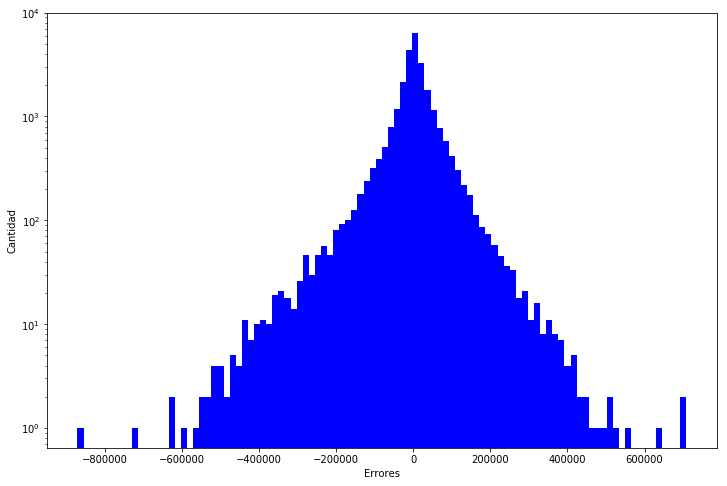

In [24]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 100, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-1000, 1000) #para variar el "zoom a 0"
plt.yscale('log')
plt.show()

###  Distribucion de precios

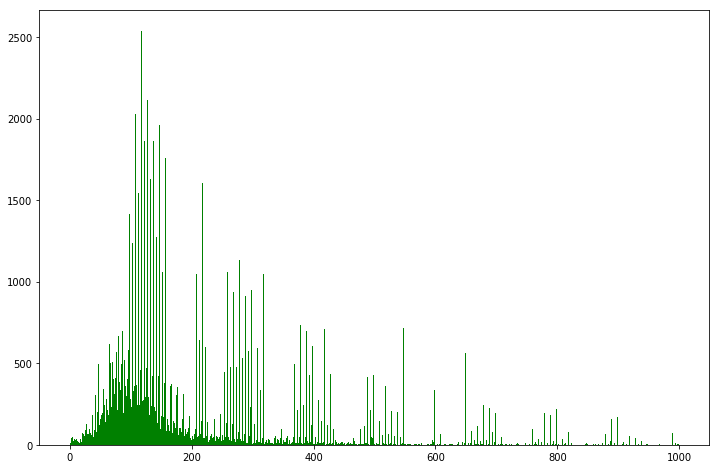

In [312]:
plt.figure(figsize=(12,8))
cant_buckets=1000
cantidad,rango = np.histogram(properati['price_aprox_usd'], bins=cant_buckets)
properati['categories_by_price']=pd.cut(properati['price_aprox_usd'],rango,labels=np.arange(cant_buckets),include_lowest=True)
plt.hist(properati.categories_by_price,cant_buckets,facecolor='green')
plt.show()

## Pruebo reduccion con RF

In [ ]:
X = zip(properati['dist_a_subte'],properati['dist_a_univ'],properati['dist_a_tren'],properati['dist_a_villa'],\
        properati['dist_a_zona_anegada'],properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['lat'],properati['lon'])

y = properati['price_aprox_usd']

X=scaler.fit_transform(X,y)

In [ ]:
%%notify

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

estimators = [('pca', PCA()), ('rf', RandomForestRegressor())]
pipe = Pipeline(estimators)

criterion = ['mse']
max_features =['log2']
n_estimators = np.arange(170,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid= dict( pca__n_components=np.arange(1,8,1),rf__criterion = criterion,
rf__max_features =max_features,
rf__n_estimators = n_estimators)

grid_search = GridSearchCV(pipe, param_grid=param_grid,n_jobs=-1,refit=True,cv=5)

grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_estimator_.score(X_test,y_test)

In [ ]:
estimador_pipe=grid_search.best_estimator_
estimador_pipe

In [ ]:
estimador_pipe.get_params
estimador_pipe.steps[1][1].feature_importances_

In [ ]:
errores = estimador_pipe.predict(X_test)-y_test

In [ ]:
 # the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 100, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-1000, 1000) #para variar el "zoom a 0"
plt.yscale('log')
plt.show()

# Probando set Kaggle

In [2]:
#paso features con strings a numericos
le_barrio = preprocessing.LabelEncoder()
barrios=properati['state_name']
le_barrio.fit(barrios)
properati['state_name'] = le_barrio.transform(barrios)

le_zona = preprocessing.LabelEncoder()
zona=properati['place_name']
le_zona.fit(zona)
properati['place_name'] = le_zona.transform(zona)

le_tipo = preprocessing.LabelEncoder()
tipos_prop=properati['property_type']
le_tipo.fit(tipos_prop)
properati['property_type'] = le_tipo.transform(tipos_prop)

In [3]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['property_type'],properati['state_name'],properati['place_name'])
y = properati['surface_total_in_m2']

In [6]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =['log2']
n_estimators = [80]

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = GridSearchCV(rf, param_grid=param_grid ,cv=20,scoring="neg_mean_squared_error") #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X, y)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 96.35 segundos para 1 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: -4138.260 (std: 884.852)
Promedio validation score: -27064.770 (std: 22637.812)
Promedio fit time: 3.522s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 80, 'criterion': 'mse'}



<IPython.core.display.Javascript object>

In [ ]:
test = pd.read_csv('datos/properati_dataset_testing_noprice.csv')

In [ ]:
 def recalcular_superficie(row):
    if ( np.isnan(row.surface_total_in_m2) and (row.surface_covered_in_m2 !=0) ): #si no tiene la sup total usa la descubierta como total 
        row.surface_total_in_m2 = row.surface_covered_in_m2
    if ( np.isnan(row.surface_covered_in_m2) and (row.surface_total_in_m2 !=0)): #si no tiene la sup total usa la descubierta como total 
        row.surface_covered_in_m2 = row.surface_total_in_m2
    return row
test = test.apply(recalcular_superficie,axis=1)

In [ ]:
test.info()

In [ ]:
estimador_final = search.best_estimator_

In [ ]:
#paso features con strings a numericos
le_barrio = preprocessing.LabelEncoder()
barrios=test['state_name']
le_barrio.fit(barrios)
test['state_name'] = le_barrio.transform(barrios)

le_zona = preprocessing.LabelEncoder()
zona=test['place_name']
le_zona.fit(zona)
test['place_name'] = le_zona.transform(zona)

le_tipo = preprocessing.LabelEncoder()
tipos_prop=test['property_type']
le_tipo.fit(tipos_prop)
test['property_type'] = le_tipo.transform(tipos_prop)
print le_tipo.get_params()

In [ ]:
Z = zip(test['surface_total_in_m2'],\
        test['surface_covered_in_m2'],test['property_type'],test['state_name'],test['place_name'])